In [1]:
%matplotlib inline

In [2]:
from __future__ import division
from __future__ import unicode_literals

import logging
import os
import random

import numpy as np
import pandas as pd
import torch as tc
import torch.utils.data as tc_data
import tqdm

import preprocessing
import model_utils as mu
import s2s_autoencoder as s2s
import tensorboard as tb

from pprint import pprint
from matplotlib import pyplot as plt
from IPython.display import display, HTML


plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']= (10, 5)

pd.options.display.max_colwidth = 75
pd.options.display.width = 150
pd.options.display.max_columns = 40
css = open('/nail/home/visp/ipython/style-table.css').read()
HTML('<style>{}</style>'.format(css))

is_cuda: False


### Load data

In [3]:
REVIEW_FL = 'data/yelpds11/review.json'
W2V_FILE = 'data/glove.6B/glove.6B.100d.txt'
N_REVIEWS = 20000
MAX_LEN = 20

In [4]:
w2v_data = preprocessing.load_w2v_data(path=W2V_FILE)

Loading embeddings: 100%|██████████| 400000/400000 [00:16<00:00, 24529.69it/s]
preprocessing.py:84: RuntimeWarning: covariance is not positive-semidefinite.
  size=n_special_tokens,


In [5]:
w2v_data.lang.w2ix.keys()[:10]

['<SOS>', '<EOS>', '<PADDING>', '<UNK>', 'the', ',', '.', 'of', 'to', 'and']

In [6]:
split_data = preprocessing.load_and_split_reviews(
    review_fl=REVIEW_FL,
    lang=w2v_data.lang,
    dev_frac=0.2,
    test_frac=0.2,
    n_reviews=N_REVIEWS,
    max_len=MAX_LEN,
    min_len=5,
)

HBox(children=(IntProgress(value=0, description=u'Iter over reviews.: ', max=20000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Iter over reviews.: ', max=20000), HTML(value=u'')))

In [7]:
split_data.train.head(2)

,review_id,sent_num,sent_len,ixs,tokens,text
0,--vWmCoqCGZgcmsn7ELlUQ,0,20,"[0, 57, 121, 8, 173, 424, 29, 4333, 1075, 25, 2460, 13296, 119, 9, 7327...","[<SOS>, we, like, to, get, away, from, vegas, sometimes, by, visiting, ...",We like to get away from Vegas sometimes by visiting Boulder City and c...
1,--vWmCoqCGZgcmsn7ELlUQ,2,9,"[0, 195, 430, 2859, 21, 1178, 195, 147, 5510, 6, 1, 2, 2, 2, 2, 2, 2, 2...","[<SOS>, very, large, shop, with, everything, very, well, displayed, ., ...",Very large shop with everything very well displayed .


### Analyze how many we can drop

In [8]:
from collections import Counter

In [9]:
counter = Counter()

In [10]:
for t in tqdm.tqdm_notebook(split_data.train.tokens):
    counter.update(t)

HBox(children=(IntProgress(value=0, max=114323), HTML(value=u'')))

In [11]:
mc = counter.most_common()
display(mc[:10])
mc = mc[3:]
print
print
display(mc[:10])

[('<PADDING>', 515106),
 ('<EOS>', 114323),
 ('<SOS>', 114323),
 (u'the', 69434),
 (u'.', 60795),
 (u',', 51847),
 (u'i', 45888),
 (u'and', 44926),
 (u'a', 36299),
 (u'to', 30296)]

[(u'the', 69434),
 (u'.', 60795),
 (u',', 51847),
 (u'i', 45888),
 (u'and', 44926),
 (u'a', 36299),
 (u'to', 30296),
 (u'was', 25481),
 (u'it', 21928),
 (u'of', 19660)]

In [12]:
words, cnts = zip(*mc)

Text(0,0.5,u'Freq in log10')

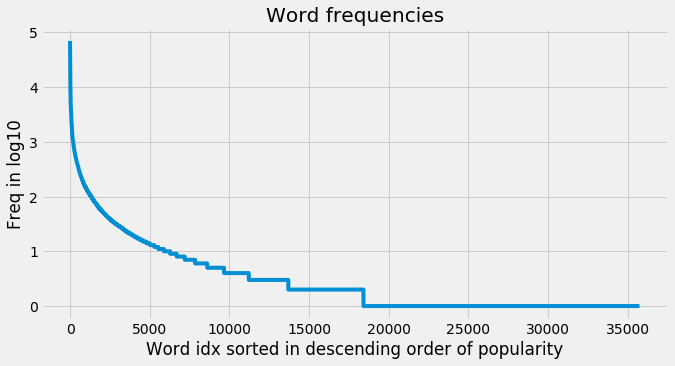

In [13]:
plt.title('Word frequencies')
plt.plot(np.log10(cnts))
plt.xlabel('Word idx sorted in descending order of popularity')
plt.ylabel('Freq in log10')

In [14]:
pd.Series(cnts).describe()

count    35736.000000
mean        43.169577
std        802.193171
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      69434.000000
dtype: float64

In [15]:
cnts[10000]

4

### Save a w2v file with 10000 most popular words

In [16]:
words[:10]

(u'the', u'.', u',', u'i', u'and', u'a', u'to', u'was', u'it', u'of')

In [17]:
selected_words = set(words[:10000])

In [18]:
MIN_W2V_FILE = 'data/glove.6B/glove.6B.100d-min.txt'

In [19]:
!head -1 data/glove.6B/glove.6B.100d.txt

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062


In [20]:
(
    'the 0.418 0.24968 -0.41242 0.1217 0.34527'
    ' -0.044457 -0.49688 -0.17862 -0.00066023 '
).split(' ', 1)[0]

u'the'

In [21]:
with open(MIN_W2V_FILE, 'w') as outfile:
    with open(W2V_FILE) as infile:
        for ln in tqdm.tqdm_notebook(infile, total=400*1000):
            if ln.split()[0] in selected_words:
                outfile.write(ln)

HBox(children=(IntProgress(value=0, max=400000), HTML(value=u'')))

In [22]:
!wc -l 'data/glove.6B/glove.6B.100d-min.txt'

    9623 data/glove.6B/glove.6B.100d-min.txt


In [23]:
!head -5 data/glove.6B/glove.6B.100d-min.txt

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158 

In [24]:
saved = set()
with open(W2V_FILE) as infile:
    for ln in tqdm.tqdm_notebook(infile, total=400*1000):
        saved.add(ln.split()[0])

HBox(children=(IntProgress(value=0, max=400000), HTML(value=u'')))

In [25]:
missing = sorted(selected_words - saved)

In [26]:
len(missing)

377

In [27]:
random.shuffle(missing)
missing[:10]

[u'manquait',
 u'.they',
 u'4:30pm',
 u'go\xfbter',
 u'\xe9viter',
 u'sooooooo',
 u"j'aurai",
 u'ayce.',
 u'burgatory',
 u'lol.']

19866/|/ 99%|| 19866/20000 [04:00<00:01, 82.76it/s]

### Clearly it sucks that some words are missing but meh